# Derived FRB Rates from the ALFABURST Survey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.integrate
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
sns.set()
sns.set_context("paper")

## Preamble

#### Observing Time Lower Limit (July 2015 - May 2017) (See Survey_Notes.ipynb):

In [3]:
obsTime = 5042760. #seconds
outOfPlaneObsTime = 2808480. #seconds

print 'Total Obs Time:', str(datetime.timedelta(seconds=obsTime)), '%f hours'%(obsTime/3600.)
print 'Out of Plane Obs Time:', str(datetime.timedelta(seconds=outOfPlaneObsTime))
print 'Precent out of plane:', (outOfPlaneObsTime / obsTime) * 100.

Total Obs Time: 58 days, 8:46:00 1400.766667 hours
Out of Plane Obs Time: 32 days, 12:08:00
Precent out of plane: 55.693310806


In [4]:
llObsTime = [1261077 + 212934,
             857322 + 156960,
             1444512 + 193889,
             997241 + 107952,
             471593 + 262572,
             308866 + 270820,
             1349927 + 223508]
llObsTime = np.array(llObsTime)
avgObsTime = llObsTime.mean() # seconds

print 'Observing Time Lower Limit:'
for bid,val in enumerate(llObsTime):
    print '  Beam%i: %i s (%f hours)'%(bid, val, val/3600.)
print 'Mean observing time: %f hours'%(avgObsTime / 3600.),
print '(Precent of total Obs time: %.1f%%)'%(100. * llObsTime.mean() / obsTime)

Observing Time Lower Limit:
  Beam0: 1474011 s (409.447500 hours)
  Beam1: 1014282 s (281.745000 hours)
  Beam2: 1638401 s (455.111389 hours)
  Beam3: 1105193 s (306.998056 hours)
  Beam4: 734165 s (203.934722 hours)
  Beam5: 579686 s (161.023889 hours)
  Beam6: 1573435 s (437.065278 hours)
Mean observing time: 322.189405 hours (Precent of total Obs time: 23.0%)


#### ALFA Beam FWHM

A single ALFA pixel is approximately 3.8' x 3.3' wide at FWHM ([REF](http://www.naic.edu/~astro/RXstatus/)). Using this we can compute the upper and lower limit survey coverage.

In [5]:
nBeams = 7. # number of beams, for ALFA this is 7
beamFWHM = (nBeams * (3.5 / 60.)) * np.pi/180. # beam FWHM in radians
print 'Beam Width: %f deg (%f rad)'%(beamFWHM * 180./np.pi, beamFWHM)

beamArea = np.pi * (beamFWHM/2.)**2. # beam area in steradians
print 'Beam Area: %f deg^2 (%f str)'%(beamArea * ((180./np.pi)**2.), beamArea)

Beam Width: 0.408333 deg (0.007127 rad)
Beam Area: 0.130954 deg^2 (0.000040 str)


## ALFA FWHM Survey Metric, Sensitivity, Standard Candle FRB Event Rate

#### Survey Metric

Using the survey observing time and the \gls{alfa} beam size we can derive the \gls{frb} survey metric of square-degree hours. An \gls*{alfa} beam is approximately 3.8' x 3.3' at \gls*{fwhm} across the band.  Using this beam size and the average observation time per beam the telescope-independent \gls*{frb} survey coverage metric for ALFABURST as of June 2017 is 6.7 square-degree hours (lower limit). This is a fairly small survey metric becuase of the small beam size.

In [6]:
pixelFWHMarea = np.pi * (3.8 / (60. * 2.)) * (3.3 / (60. * 2.)) # pi * r^2, r = (FWHM/2) in degrees
alfaFWHMarea = 7. * pixelFWHMarea

print 'ALFA beam size (using FWHM of 3.8\' x 3.3\'):'
print '  Single beam: %f sq. degrees'%pixelFWHMarea
print '  All beams: %f sq. degrees'%alfaFWHMarea

print 'Sky Coverage using all 7 beams:'
print '  Upper Limit: %f sq. degree hours'%(alfaFWHMarea * (obsTime/3600.))
print '  Lower Limit: %f sq. degree hours'%(np.sum((llObsTime/3600.) * pixelFWHMarea)) 

ALFA beam size (using FWHM of 3.8' x 3.3'):
  Single beam: 0.002736 sq. degrees
  All beams: 0.019151 sq. degrees
Sky Coverage using all 7 beams:
  Upper Limit: 26.825557 sq. degree hours
  Lower Limit: 6.170129 sq. degree hours


#### Sensitivity

Equation 6 of Karastergiou et al. 2015 is derived from the radiometer equation:

$$
S_{min} = \textrm{SEFD} \frac{\textrm{SNR}_{min}}{\sqrt{D \; \Delta \tau \; \Delta \nu}}
$$

where $S_{min}$ is the minimum flux density (in Jy) detection rate. This is based on the telescope SEFD, the minimum SNR detection level $\textrm{SNR}_{min}$ and the decimation rate $D$ compared to the native instrumental time resolution $\tau$, this comes from the search pipeline which averages together spectra to search for scattered pulses. ALFABURST has a native resolution of $\Delta \tau = 256 \; \mu s$, effective bandwidth $\Delta \nu = 56 \textrm{MHz}$, and $\textrm{SNR}_{min} = 10$.

For reference see:
* https://www.cv.nrao.edu/course/astr534/Radiometers.html
* http://www.naic.edu/alfa/performance/
* https://casper.berkeley.edu/astrobaki/index.php/Radiometer_Equation_Applied_to_Telescopes
* https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/sensitivity

In [7]:
# Parameters

# From Minimum flux density detection, based on radiometer equation
SEFD = 3. # Jy, SEFD of ALFA (main beam)
threshold = 10. # SNR threshold of detection pipeline
pulseWidth = 2.**(np.arange(0,7)) * 256. # us, expected pulse width
#pulseWidth = np.array([256., 1024., 4096., 4.*4096]) # us, expected pulse width
tRes = 256. # us, ALFABURST spectra time resolution
dFactor = pulseWidth / tRes# decimation factor
bw = 56. * 1e6 # ALFABURST effective bandwidth in Hz
sMin = SEFD * (threshold / np.sqrt(dFactor * (tRes * 1e-6) * bw))

fObsMin = 1347e6 # ALFABURST 56 MHz bandwidth system min frequency
fObsMax = 1403e6 # ALFABURST 56 MHz bandwidth system max frequency

alphas = [-2., -1.1, 0., 1., 2.] # spectral indicies to model
#alphas = [-1.4, 0., 1.4] # spectral indicies to model

zMin = 0.01
zMax = 7.997 # minimum z based on pointing and NE2001 from frb_search_volume.ipynb

In [8]:
print 'Survey metric: %f sq. degree hours'%(np.sum((llObsTime/3600.) * pixelFWHMarea))
print 'The minimum flux density detection for a given pulse width is (using the FWHM ALFA beam):'
for sMinVal, pwVal in zip(sMin, pulseWidth):
    print '\t %.1f mJy for a pulse width of %.0f us'%(sMinVal*1000., pwVal)

Survey metric: 6.170129 sq. degree hours
The minimum flux density detection for a given pulse width is (using the FWHM ALFA beam):
	 250.6 mJy for a pulse width of 256 us
	 177.2 mJy for a pulse width of 512 us
	 125.3 mJy for a pulse width of 1024 us
	 88.6 mJy for a pulse width of 2048 us
	 62.6 mJy for a pulse width of 4096 us
	 44.3 mJy for a pulse width of 8192 us
	 31.3 mJy for a pulse width of 16384 us


#### Standard Candle FRB Event Rate

Using Lorimer et. al (2013) following the assumptions that FRBs ara a standard candle and Thornton et al. 2013 correctly relates flux density to redshift we can compute the survey volume, and expected number of FRBs based on the survey time.

In [9]:
def coMovingDist(z):
    """Co-moving distance in Gpc, Eq. 3 from Lorimer et al. 2013
    z: float, redshift
    """
    c = 299792.458 # km s^-1
    H0 = 68. # km s^-1 Mpc^-1
    OmegaM = 0.32
    OmegaLambda = 0.68
    
    integrand = lambda zp: 1. / np.sqrt(OmegaM * ((1. + zp)**3.) + OmegaLambda)
    dd, err = scipy.integrate.quad(integrand, 0., z)
    return ((c/H0) * dd) * 1e-3

def coMovingVol(z):
    """Co-moving volume in Gpc^3
    z: float, redshift"""
    return (4./3.)*(coMovingDist(z)**3.)

def calcLModel(sPeakRef=1., alphaRef=-1.4, zRef=0.75, fLumMin=1e7, fLumMax=1e10, fObsMin=1182e6, fObsMax=1582e6):
    """Calculate the standard candle FRB bolometric luminosity based on Thornton et al. 2013 model, this is used
    to calibrate the flux-redshift relationship
    sPeakRef: float, Jy, peak flux density, Thornton et al.: 1.
    alphaRef: float, spectal index, Thornton et al.: -1.4
    zRef: float, redshift, Thornton et al.: 0.75
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    fObsMin: float, Hz, minimum observing frequency, Thornton et al.: 1186 MHz
    fObsMax: float, Hz, maximum observing frequency, Thornton et al.: 1582 MHz"""
    sPeakRefErgs = sPeakRef * 1e-19 # unit: erg s^-1 ; 1 Jy = 10^-26 W = 10^-19 erg s^-1
    
    dd = coMovingDist(zRef) * 3.086e25 # Convert from Gpc to m

    LL = ((fObsMax-fObsMin)/((fObsMax**(alphaRef+1.))-(fObsMin**(alphaRef+1.)))) * sPeakRefErgs \
            * 4. * np.pi * (dd**2.) \
            * (((fLumMax**(alphaRef+1.))-(fLumMin**(alphaRef+1.)))/((1.+zRef)**(alphaRef-1.)))
    return LL

def calcSpeak(LModel, z, alpha, fObsMin, fObsMax, fLumMin=1e7, fLumMax=1e10):
    """Calculate the peak flux density, Lorimer et al. 2013 eq. 9
    LModel: float, ergs s^-1, bolometric luminosity model output of calcLModel()
    z: float, redshift of source
    alpha: float, spectral index of FRB standard candle model
    fObsMin: float, Hz, minimum observing frequency
    fObsMax: float, Hz, maximum observing frequency
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    """
    dd = coMovingDist(z) * 3.086e25 # Convert from Gpc to m
    
    sPeak = (LModel * ((1. + z)**(alpha-1.))) \
            * (1. / (4. * np.pi * dd**2. * ((fLumMax**(alpha+1.)) - (fLumMin**(alpha+1.)))) ) \
            * (((fObsMax**(alpha+1.)) - (fObsMin**(alpha+1.)))/(fObsMax - fObsMin))

    return sPeak / 1e-19

Smin: 250.557414 mJy 	 Alpha: -2.000000 	 zMax: 1.196729
Smin: 250.557414 mJy 	 Alpha: -1.100000 	 zMax: 1.306033
Smin: 250.557414 mJy 	 Alpha: 0.000000 	 zMax: 1.532449
Smin: 250.557414 mJy 	 Alpha: 1.000000 	 zMax: 2.094584
Smin: 250.557414 mJy 	 Alpha: 2.000000 	 zMax: 3.773181
Smin: 177.170847 mJy 	 Alpha: -2.000000 	 zMax: 1.345070
Smin: 177.170847 mJy 	 Alpha: -1.100000 	 zMax: 1.493412
Smin: 177.170847 mJy 	 Alpha: 0.000000 	 zMax: 1.852553
Smin: 177.170847 mJy 	 Alpha: 1.000000 	 zMax: 2.984630
Smin: 177.170847 mJy 	 Alpha: 2.000000 	 zMax: 3.773181
Smin: 125.278707 mJy 	 Alpha: -2.000000 	 zMax: 1.501219
Smin: 125.278707 mJy 	 Alpha: -1.100000 	 zMax: 1.712020
Smin: 125.278707 mJy 	 Alpha: 0.000000 	 zMax: 2.258540
Smin: 125.278707 mJy 	 Alpha: 1.000000 	 zMax: 4.600768
Smin: 125.278707 mJy 	 Alpha: 2.000000 	 zMax: 3.773181
Smin: 88.585423 mJy 	 Alpha: -2.000000 	 zMax: 1.680790
Smin: 88.585423 mJy 	 Alpha: -1.100000 	 zMax: 1.969665
Smin: 88.585423 mJy 	 Alpha: 0.000000 	 zM

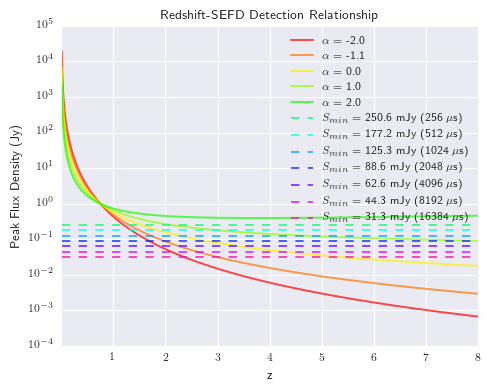

In [10]:
fig = plt.figure(figsize=(5, 4)) # width, height

zArr = np.linspace(zMin, zMax, 1024)
sPeakArr = np.zeros((len(alphas), len(zArr)))

cmap = plt.cm.hsv
colors = iter(cmap(np.linspace(0, 0.9, len(alphas) + len(sMin))))

for aid, alpha in enumerate(alphas):
    LModel = calcLModel(alphaRef=alpha)
    for zid,zz in enumerate(zArr):
        sPeakArr[aid, zid] = calcSpeak(LModel, zz, alpha, fObsMin, fObsMax)
    plt.semilogy(zArr, sPeakArr[aid], color=next(colors), alpha=0.7, label=r'$\alpha =$ %1.1f'%alpha)

idxArr = np.zeros((len(sMin),len(alphas)), dtype='int')
#for sMinVal, pwVal in zip(sMin, pulseWidth):
for smid, sMinVal in enumerate(sMin):
    pwVal = pulseWidth[smid]
    plt.axhline(y=sMinVal, xmin=0.0, xmax=1.0, color=next(colors), linestyle="--", alpha=0.7, \
                #label='$S_{min}=$ %1.1f mJy (%.0f ms)'%(sMinVal*1000., pwVal/1000.))
                label='$S_{min}=$ %1.1f mJy (%.0f $\mu$s)'%(sMinVal*1000., pwVal))
    for aid, alpha in enumerate(alphas):
        idx = np.argmin(np.abs(sPeakArr[aid] - sMinVal)) # array index of nearest sMin/alpha flux density crossing
        #print alpha, sMinVal, idx, zArr[idx]
        idxArr[smid, aid] = idx
        # find maximum redshift to compute volume
        print 'Smin: %f mJy \t Alpha: %f \t zMax: %f'%(sMinVal*1000., alpha, zArr[idx])

plt.legend()
plt.xlim(zMin, zMax)
plt.xlabel('z')
plt.ylabel('Peak Flux Density (Jy)')
plt.title('Redshift-SEFD Detection Relationship')
plt.tight_layout()

plt.savefig('fwhm_sefd_z_relation.pdf')

**Figure:** Similar to Figure 6 of Karastergiou et al. 2015, and Figure 2a of Lorimer et al. 2013. Peak flux density of the Lorimer et al. 2013 population model as a function of redshift $z$ and spectral index $\alpha$. Lines of minimum dectection using the ALFABURST system is shown as dashed lines for different decimation levels.

#### Survey Volume

Taking a simple flat spectrum source and a pulse width of 4 ms we can compute the volume surveyed.

In [11]:
print pulseWidth
print alphas

[   256.    512.   1024.   2048.   4096.   8192.  16384.]
[-2.0, -1.1, 0.0, 1.0, 2.0]


In [12]:
fwhmPWIdx = 4 # test case: index of pulse width 4096 us
fwhmAIdx = 2 # test case: index of 0.0 spectral index
fwhmSMin = sMin[fwhmPWIdx]
print 'Minimum detection limit for a pulse with width %.0f assuming an alpha=%.1f source: %f mJy'%\
    (pulseWidth[fwhmPWIdx], alphas[fwhmAIdx],fwhmSMin*1000.)

fwhmZmax = zArr[idxArr[fwhmPWIdx, fwhmAIdx]]
print 'Maximum redshift based on sensitivity/standard candle cross-over point: z=%f'%fwhmZmax
    
# Constants
deg2rad = np.pi / 180.
rad2deg = 180. / np.pi
Gpc32Mpc3 = 1e9 # convert Gpc^3 to Mpc^3
nGalaxies = 1e-2 # number density of galaxies, Mpc^-3

dd = coMovingDist(fwhmZmax)
print 'Comoving distance: %f Gpc'%dd
# Volume, assuming a cone, V = pi r^2 h / 3, where r = dd theta / 2 (small angle approximation), and h = dd
# this ignores any sensitivity beyond the beam FWHM
surveyVol = (np.pi * ((dd * (beamFWHM/2.))**2.) * dd) / 3.
surveyVol *= Gpc32Mpc3 # convert from Gpc^3 to Mpc^3
nSurveyGal = int(surveyVol * nGalaxies)  # number of galaxies in volume

print 'Survey Volume: %f Mpc^3'%surveyVol
print 'Galaxies in volume:', nSurveyGal

Minimum detection limit for a pulse with width 4096 assuming an alpha=0.0 source: 62.639354 mJy
Maximum redshift based on sensitivity/standard candle cross-over point: z=3.421847
Comoving distance: 6.794144 Gpc
Survey Volume: 4170203.413148 Mpc^3
Galaxies in volume: 41702


#### Number of Expected Detections

Using the volumetric event rate of $R_{FRB} = 10^{-3}$ FRBs per galaxy per year from Thornton et al 2013 we can compute our expected number of detections.

In [13]:
FRBvolRate = 1e-3 # from Thornton et al 2013
avgObsTimeYrs = avgObsTime / (60. * 60. * 24. * 365.)
print 'Survey Time: %f years'%avgObsTimeYrs

print 'Expected Number of FRBs in Survey: %f'%(FRBvolRate * nSurveyGal * avgObsTimeYrs)

Survey Time: 0.036780 years
Expected Number of FRBs in Survey: 1.533783


## ALFA Full Beam Survey Metric and Sensitivity

We are only taking into account the beam size out to the \gls{fwhm}. We can take into acount the entire first sidelobes of the beams as Arecibo would be senstive enough to detect most previous \glspl{frb} in the first sidelobes. Using the parameterized \gls{alfa} beam model (Figure \ref{fig:alfa_beam}) \citep{GALFAbeam} we can compute the \gls{frb} survey metric as a function of the minimum \gls{alfa} sensitvity (Figure \ref{fig:survey_metric}).

## ALFA Primary and First Side Lobe Stokes I Beam Model

Based on [GALFA Technical Memo 2004-01](http://www.astro.cornell.edu/~haynes/pre204/docs/heiles_beams.pdf)

This is a notebook which implements the parameterized ALFA beam model from Carl Heiles' 2004 memo from the GALFA survey. This parameterization only accounts for the primary lobe and first sidelobe.

### Parameterized Primary Lobe Model

The beam width scales as a function of frequency slower than a typical diffraction-limited lens.

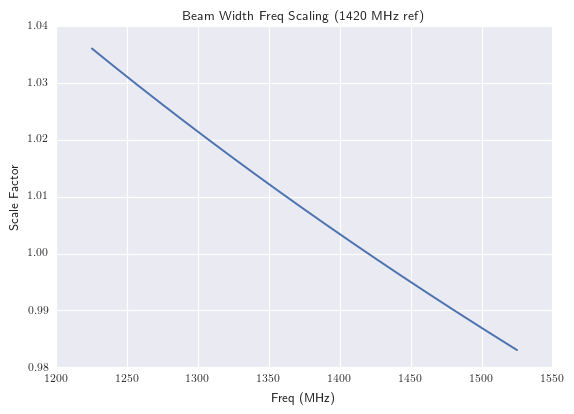

In [14]:
# Beam width frequency dependence
freqsMHz = np.linspace(1225, 1525, 1024)
scaleFactor = (freqsMHz / 1420.)**(-0.24)

sns.set_style("darkgrid")
plt.plot(freqsMHz, scaleFactor)
plt.xlabel('Freq (MHz)')
plt.ylabel('Scale Factor')
plt.title('Beam Width Freq Scaling (1420 MHz ref)')

In [15]:
# Parameterized Stokes I primary lobe

# Table 1 Primary Lobe Parameters
hpbwArcMin = 3.35 # Half-Power Beam Width in arcmin
hpbwDeltaF = -0.18 # Derivative of the HPWB as a function of frequency d(hpbwArcMin) / d(100 MHz)
ellipArcMin = 0.22 # Beam ellipticity in arcmin
ellipPA = np.pi/2 # Position angle of the ellipse, in radians
comaAmp = 0. # amplitude of the coma abberation
comaPA = 0. # Position angle of the coma abberation, in radians

# derived parameters
beamWidth = (hpbwArcMin / 1.665) * (1/60.) * (np.pi/180.)
ellip = ellipArcMin / hpbwArcMin
Theta0 = (2. * beamWidth / (np.sqrt(1. - ellip**2.) + 1.))
Theta1 = (2. * beamWidth - Theta0)

def normPrimaryLobe(phi, theta, freq=1420.):
    """phi: azimuth angle, in radians
    theta: altitude angle, in arcmin
    freq: float, obersving frequency in MHz"""
    thetaScaled = theta / (freq / 1420.)**(-0.24)
    thetaRad = thetaScaled * (1/60.) * (np.pi/180.)
    return np.exp( -1. * thetaRad**2. * (1. - (comaAmp * comaPA / Theta0)) / \
                  (Theta0 * Theta1 / np.sqrt( (Theta0 * np.cos(phi - ellipPA))**2. + (Theta1 * np.sin(phi - ellipPA))**2. ))**2.)
    #return np.exp( -1. * thetaRad**2. * (1. - (comaAmp * comaPA / Theta0)) / (Theta0 + Theta1 * np.cos(2. * (phi - ellipPA)))**2.)

In [16]:
# Generate the primary beam image

xSize = 256
ySize = 256
xWidth = 20. # arcmin
yWidth = 20. # arcmin
obsFreq = 1420. # MHz

xRange = np.linspace(-1.*xWidth/2., xWidth/2., xSize)
yRange = np.linspace(-1.*yWidth/2., yWidth/2., ySize)
xx, yy = np.meshgrid(xRange, yRange)

rr = np.sqrt(xx**2. + yy**2.)
phis = np.arctan2(yy, xx)

primaryLobeResp = np.zeros((xSize, ySize))

for ii in np.arange(xSize):
    for jj in np.arange(ySize):
        primaryLobeResp[ii, jj] = normPrimaryLobe(phis[ii, jj], rr[ii, jj], freq=obsFreq)

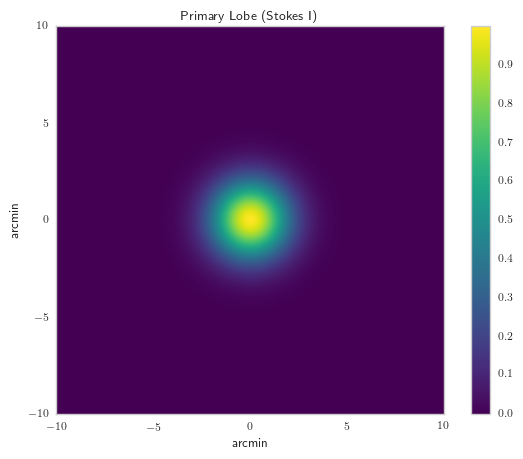

In [17]:
# Plot a primary beam image

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(np.abs(primaryLobeResp), cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('Primary Lobe (Stokes I)')
plt.ylabel('arcmin')
plt.xlabel('arcmin')

### Parameterized First Sidelobe Model

In [18]:
# read in Fourier coefficients file
fourierCoeffFile = 'ALFAfourier.dat'

hgtArr = np.zeros((7, 8), dtype='complex')
cenArr = np.zeros((7, 8), dtype='complex')
widArr = np.zeros((7, 8), dtype='complex')

with open (fourierCoeffFile, 'r') as fh:
    data = fh.read()
lines = data.split('\n')

for fid in np.arange(7):
    hgtArr[fid] = np.array(map(float,lines[3 + fid*7].split(' ')[2:])) + 1j * np.array(map(float,lines[4 + fid*7].split(' ')[2:]))
    cenArr[fid] = np.array(map(float,lines[5 + fid*7].split(' ')[2:])) + 1j * np.array(map(float,lines[6 + fid*7].split(' ')[2:]))
    widArr[fid] = np.array(map(float,lines[7 + fid*7].split(' ')[2:])) + 1j * np.array(map(float,lines[8 + fid*7].split(' ')[2:]))

In [19]:
# Functions to generate the sidelobe using fitted Fourier coefficients

def hgtCoeff(phi, feed):
    """eq 5a
    phi: angle in radian
    feed: ALFA feed ID"""
    idx = np.roll(np.arange(-4, 4), 4)
    return np.sum(hgtArr[feed] * np.exp(2. * np.pi * 1j * idx * (phi / (2. * np.pi))))

def cenCoeff(phi, feed):
    """eq 5a
    phi: angle in radian
    feed: ALFA feed ID"""
    idx = np.roll(np.arange(-4, 4), 4)
    return np.sum(cenArr[feed] * np.exp(2. * np.pi * 1j * idx * (phi / (2. * np.pi))))

def widCoeff(phi, feed):
    """eq 5a
    phi: angle in radian
    feed: ALFA feed ID"""
    idx = np.roll(np.arange(-4, 4), 4)
    return np.sum(widArr[feed] * np.exp(2. * np.pi * 1j * idx * (phi / (2. * np.pi))))

def firstSideLobeResponse(phi, r, feed, freq=1420.):
    """eq 5b
    Note: eq 5b does not include the -1 in the exponent, this is corrected here
    phi: angle in radian
    r: distance from beam centre in arcmin
    freq: float, obersving frequency in MHz"""
    rScaled = r / ((freq / 1420.)**(-0.24)) # eq 4a
    return hgtCoeff(phi, feed) * np.exp( -1. * ((rScaled - cenCoeff(phi, feed))**2.) / ((0.6005612 * widCoeff(phi, feed))**2.))

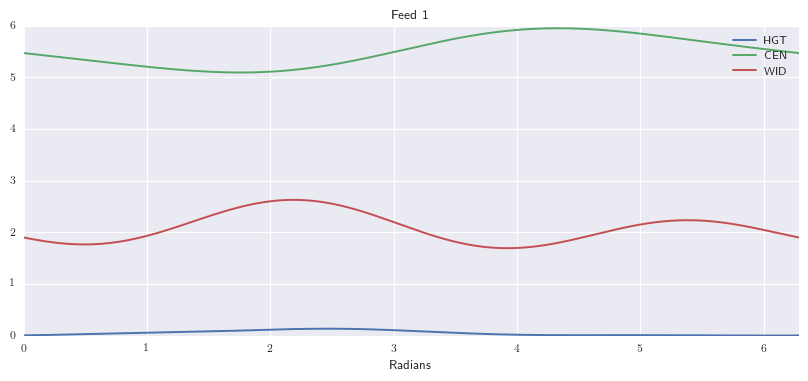

In [20]:
# 1-d functions
feedID = 1

phis = np.linspace(0, 2. * np.pi, 1024)
hgtResp = np.zeros(1024, dtype='complex')
cenResp = np.zeros(1024, dtype='complex')
widResp = np.zeros(1024, dtype='complex')
for ii in np.arange(1024):
    hgtResp[ii] = hgtCoeff(phis[ii], feedID)
    cenResp[ii] = cenCoeff(phis[ii], feedID)
    widResp[ii] = widCoeff(phis[ii], feedID)

sns.set_style("darkgrid")
fig = plt.figure(figsize=(10, 4)) # width, height
plt.plot(phis, np.abs(hgtResp), label='HGT')
plt.plot(phis, np.abs(cenResp), label='CEN')
plt.plot(phis, np.abs(widResp), label='WID')
plt.xlim(0, 2.*np.pi)
plt.xlabel('Radians')
plt.title('Feed %i'%feedID)
plt.legend()

In [21]:
# Generate the first side lobe

feedID = 6

xSize = 256
ySize = 256
xWidth = 20. # arcmin
yWidth = 20. # arcmin

xRange = np.linspace(-1.*xWidth/2., xWidth/2., xSize)
yRange = np.linspace(-1.*yWidth/2., yWidth/2., ySize)
xx, yy = np.meshgrid(xRange, yRange)

rr = np.sqrt(xx**2. + yy**2.)
phis = np.arctan2(yy, xx)

sideLobeResp = np.zeros((xSize, ySize), dtype='complex')

for ii in np.arange(xSize):
    for jj in np.arange(ySize):
        sideLobeResp[ii, jj] = firstSideLobeResponse(phis[ii, jj], rr[ii, jj], feedID)

sideLobeStokesI = np.abs(sideLobeResp)

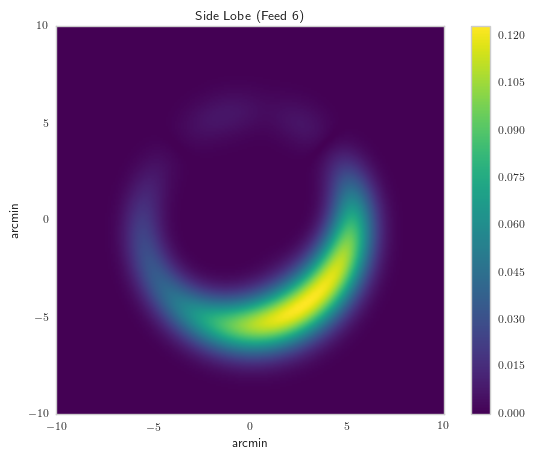

In [22]:
# Plot the first side lobe

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(np.abs(sideLobeStokesI), cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('Side Lobe (Feed %i)'%feedID)
plt.ylabel('arcmin')
plt.xlabel('arcmin')

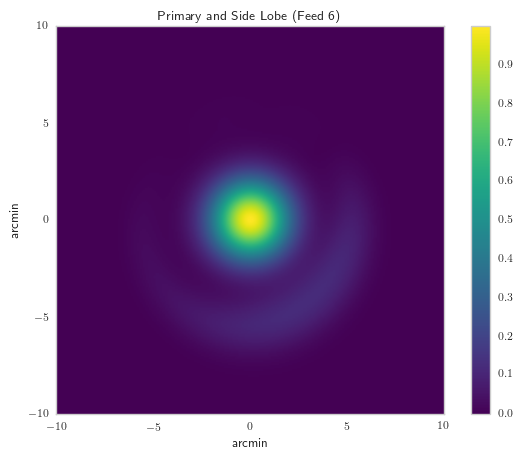

In [23]:
# Plot the primary lobe and first side lobe

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(primaryLobeResp + sideLobeStokesI, cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('Primary and Side Lobe (Feed %i)'%feedID)
plt.ylabel('arcmin')
plt.xlabel('arcmin')

### All ALFA Beams

In [24]:
# Generate an image of the full ALFA system

# Table 2: beam position offsets
xxBeamOff = np.array([0., 164.5, 329.1, 164.5, -164.5, -329.1, -164.5]) / 60. # arcmin
yyBeamOff = np.array([0., -332.6, 0., 332.6, 332.6, 0., -332.6]) / 60. # arcmin

obsFreq = 1425. # MHz

xSize = 256
ySize = 256
xWidth = 30. # arcmin
yWidth = 30. # arcmin

xRange = np.linspace(-1.*xWidth/2., xWidth/2., xSize)
yRange = np.linspace(-1.*yWidth/2., yWidth/2., ySize)

beamResp = np.zeros((xSize, ySize), dtype='float')

for fid in np.arange(7):
    xx, yy = np.meshgrid(xRange + xxBeamOff[fid], yRange + yyBeamOff[fid])

    rr = np.sqrt(xx**2. + yy**2.)
    phis = np.arctan2(yy, xx)

    for ii in np.arange(xSize):
        for jj in np.arange(ySize):
            beamResp[ii, jj] += normPrimaryLobe(phis[ii, jj], rr[ii, jj])
            beamResp[ii, jj] += np.abs(firstSideLobeResponse(phis[ii, jj], rr[ii, jj], fid, freq=obsFreq))

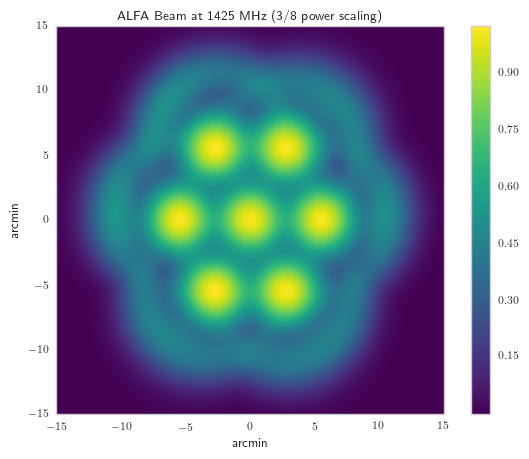

In [25]:
# Plot the ALFA receiver using 3/8 power scaling, same as Fig 12 of the memo

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(7, 5)) # width, height
plt.imshow(beamResp**(3./8.), cmap=plt.get_cmap('viridis'),\
           extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar()
plt.title('ALFA Beam at %i MHz (3/8 power scaling)'%int(obsFreq))
plt.ylabel('arcmin')
plt.xlabel('arcmin')

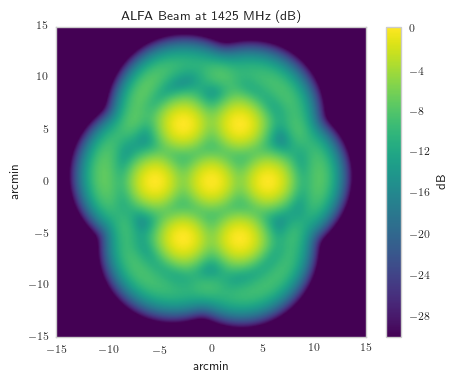

In [26]:
# Plot the ALFA receiver in dBs

dBbeamResp = 10. * np.log10(beamResp)
dBbeamResp = np.clip(dBbeamResp, a_min=-30., a_max=np.max(dBbeamResp))

sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(5, 4)) # width, height
plt.imshow(dBbeamResp, cmap=plt.get_cmap('viridis'), extent=(-1.*xWidth/2., xWidth/2., -1.*yWidth/2., yWidth/2.))
plt.colorbar(label='dB')
plt.title('ALFA Beam at %i MHz (dB)'%int(obsFreq))
plt.ylabel('arcmin')
plt.xlabel('arcmin')
plt.savefig('ALFA_beam_1425MHz_dB.pdf')

#### Survey Metric

We will continue to use the test case of a flat spectrum source and a pulse width of 4 ms. The survey metric varies as a function of the beam size. By using a larger beam size we increase the survey metric, but decrease the sensitivity and thus decrease the maximum redshift probed.

We compute the survey metric as a function of beam size based on decibel cutoff.

In [27]:
fwhmPWIdx = 4 # test case: index of pulse width 4096 us
fwhmAIdx = 2 # test case: index of 0.0 spectral index
fwhmSMin = sMin[fwhmPWIdx] #/ 2. # account for SEFD beam gain ambiguity
alpha = alphas[fwhmAIdx]
pw = pulseWidth[fwhmPWIdx]

print 'Minimum detection limit for a pulse with width %.0f assuming an alpha=%.1f source: %f mJy'%\
    (pulseWidth[fwhmPWIdx], alphas[fwhmAIdx],fwhmSMin*1000.)

Minimum detection limit for a pulse with width 4096 assuming an alpha=0.0 source: 62.639354 mJy


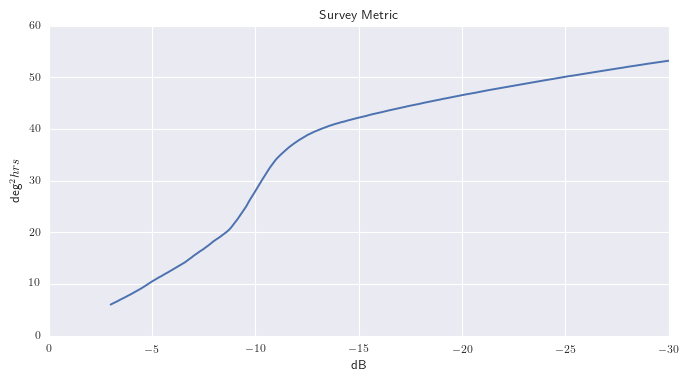

In [28]:
totalPix = float(xSize * ySize)
totalCoverage = (xWidth / 60.) * (yWidth / 60.) # sky coverage of image in deg^2
avgObsTimeHrs = avgObsTime / (60. * 60.) # hours

steps = 256
sensLevel = np.linspace(-3, -30, steps)
surveyMetric = np.zeros(steps)
for sid,sl in enumerate(sensLevel):
    nPix = len(dBbeamResp[np.where(dBbeamResp > sl)])
    surveyMetric[sid] = (nPix / totalPix) * totalCoverage * avgObsTimeHrs

sns.set_style("darkgrid")
fig = plt.figure(figsize=(8, 4)) # width, height
plt.plot(sensLevel, surveyMetric)
plt.gca().invert_xaxis()
plt.xlabel('dB')
plt.ylabel('deg^2 hrs')
plt.title('Survey Metric')

#### Sensitivity

The -3 dB point is the FWHM point, we can use this point to convert the beam gain in decibels to minimum sensitivity.

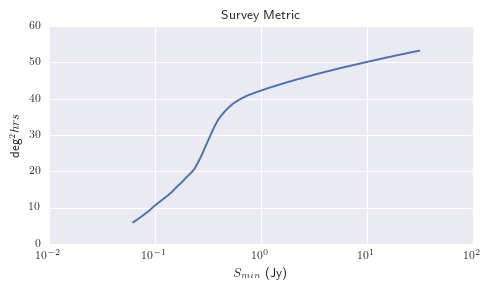

In [29]:
beamSmin = 1./(10.**(sensLevel/10.)) * 0.5 * fwhmSMin # 3 dB is at the 1/2 power point

sns.set_style("darkgrid")
fig = plt.figure(figsize=(5, 3)) # width, height
plt.semilogx(beamSmin, surveyMetric)
plt.xlabel('$S_{min}$ (Jy)')
plt.ylabel('deg^2 hrs')
plt.title('Survey Metric')
plt.tight_layout()

plt.savefig('full_survey_metric_sense.pdf')

#### Maximum Redshift

Using the standard candle model we can derive the maximum detectable redshift as a function of the beam gain/minimum sensitivity.

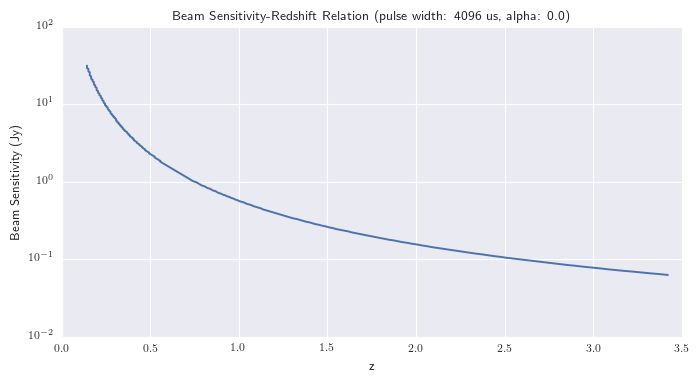

In [30]:
zArr = np.linspace(zMin, zMax, 1024)
sPeakArr = np.zeros(len(zArr)) # Standard candle Speak

LModel = calcLModel(alphaRef=alpha)
for zid,zz in enumerate(zArr):
    sPeakArr[zid] = calcSpeak(LModel, zz, alpha, fObsMin, fObsMax)

beamZmax = np.zeros_like(beamSmin)
for bsmid, bsm in enumerate(beamSmin):
    # find the closest model Speak to the beam Smin to associate a redshift to the beam gain
    idx = np.argmin(np.abs(sPeakArr - bsm))
    #print bsm, sPeakArr[idx], zArr[idx]
    beamZmax[bsmid] = zArr[idx]
    
sns.set_style("darkgrid")
fig = plt.figure(figsize=(8, 4)) # width, height
plt.semilogy(beamZmax, beamSmin)
plt.xlabel('z')
plt.ylabel('Beam Sensitivity (Jy)')
plt.title('Beam Sensitivity-Redshift Relation (pulse width: %.0f us, alpha: %.1f)'%(pw, alpha))

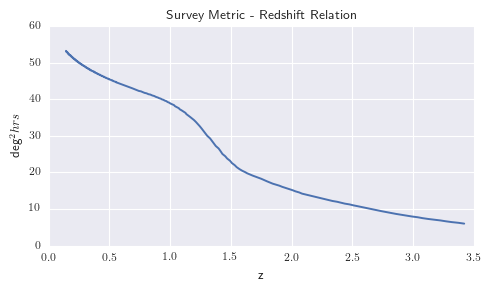

In [31]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(5, 3)) # width, height
plt.plot(beamZmax, surveyMetric)
plt.xlabel('z')
plt.ylabel('deg^2 hrs')
plt.title('Survey Metric - Redshift Relation')
plt.tight_layout()

plt.savefig('full_sefd_z_relation.pdf')

#### Survey Volume

Now we can integrate over the beam to compute the the total search volume.

Survey Volume: 5798229.007595 Mpc^3
Galaxies in volume: 57982


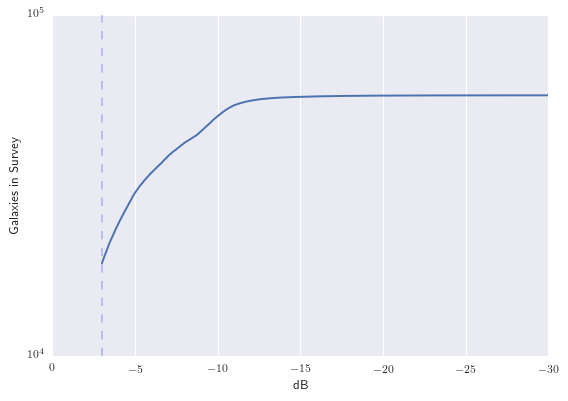

In [32]:
degSq2str = 1./((180. / np.pi)**2.)
totalCoverageSter = totalCoverage * degSq2str # total beam image in steradians

addionalVolumes = []
totalSurVolume = 0. # Mpc^3
prevBeamArea = 0.

for bzMax, bsMin in zip(beamZmax, beamSmin):
    dBs = 10. * np.log10((0.5 * fwhmSMin) / bsMin)
    nPix = len(dBbeamResp[np.where(dBbeamResp > dBs)])
    beamArea = (nPix / totalPix) * totalCoverageSter
    
    dd = coMovingDist(bzMax) # compute the Hubble distance, in Gpc
    
    # Volume, assuming a cone, V = pi r^2 h / 3, where r = dd theta / 2 (small angle approximation), and h = dd
    # this ignores any sensitivity beyond the beam FWHM
    vol = (np.pi / 3.) * (dd**2. * beamArea) * dd
    
    # we need to subtract the volumne the previous beam section sampled out to the maximum redshift of this
    # beam cutoff sensitivity
    prevVol = (np.pi / 3.) * (dd**2. * prevBeamArea) * dd
    addVol = vol - prevVol
    addVol *= Gpc32Mpc3 # convert from Gpc^3 to Mpc^3
    addionalVolumes.append(addVol)
    #print addVol
    totalSurVolume += addVol
    
    prevBeamArea = beamArea

nSurveyGal = int(totalSurVolume * nGalaxies)  # number of galaxies in volume
addionalVolumes = np.array(addionalVolumes)
plt.semilogy(sensLevel, np.cumsum(addionalVolumes) * nGalaxies)
plt.gca().invert_xaxis()
plt.xlabel('dB')
#plt.ylabel('Survey Volume (Gpc$^3$)')
plt.ylabel('Galaxies in Survey')

plt.axvline(x=-3., ymin=0.0, ymax=1.0, linestyle="--", alpha=0.2)

print 'Survey Volume: %f Mpc^3'%totalSurVolume
print 'Galaxies in volume:', nSurveyGal

#### Number of Expected Detections

Using the volumetric event rate of $R_{FRB} = 10^{-3}$ FRBs per galaxy per year from Thornton et al 2013 we can compute our expected number of detections.

In [33]:
FRBvolRate = 1e-3 # from Thornton et al 2013
avgObsTimeYrs = avgObsTime / (60. * 60. * 24. * 365.)
print 'Survey Time: %f years'%avgObsTimeYrs

print 'Expected Number of FRBs in Survey: %f'%(FRBvolRate * nSurveyGal * avgObsTimeYrs)

Survey Time: 0.036780 years
Expected Number of FRBs in Survey: 2.132555
